In [ ]:
!pip -q install pyriemann

In [95]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from pyriemann.estimation import Covariances
from pyriemann.utils.mean import mean_riemann
from pyriemann.utils.tangentspace import tangent_space

import seaborn as sns

from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D

from tqdm.auto import tqdm
from sklearn.decomposition import PCA

sns.set_style("whitegrid")

In [346]:
class PhaseTransformer(nn.Module):
    def __init__(self, model_dim=64, seq_len=1000, out_dim=3, nhead=4, num_layers=1):
        super().__init__()

        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=nhead, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        decoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=nhead, batch_first=True
        )
        self.decoder = nn.TransformerEncoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(model_dim, out_dim)

    def forward(self, src):
        src = src + self.pos_encoding
        latent_space = self.encoder(src)
        reconstruction = self.decoder(latent_space)
        return self.output_proj(latent_space), reconstruction

In [347]:
fs = 1000
T = 40.0
t = np.linspace(0, T, int(fs * T), endpoint=False)

y = (
    np.sin(2 * np.pi * 3 * t)
    + 0.5 * np.sin(2 * np.pi * 7 * t)
    + 0.15 * np.sin(2 * np.pi * 6.5 * t**1.05)
)
X = np.tanh(y)

In [348]:
def delay_embedding(signal, m, tau):
    N = len(signal)
    M = N - (m - 1) * tau
    embedded = np.zeros((M, m))
    for i in range(m):
        embedded[:, i] = signal[i * tau : i * tau + M]
    return embedded

In [349]:
m, tau = 64, 50

X_emb = delay_embedding(X, m, tau)
y_emb = delay_embedding(y, m, tau)

y_regression = PCA(n_components=3).fit_transform(y_emb)

X_train_emb = X_emb[: int(len(X) * 0.75)]
X_test_emb = X_emb[int(len(X) * 0.75) :]

y_train = y_regression[: int(len(X) * 0.75)]
y_test = y_regression[int(len(X) * 0.75) :]

In [350]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.tensor(X_train_emb, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test_emb, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

l = min(len(X_train), len(y_train))
X_train = X_train[:l]
y_train = y_train[:l]

l = min(len(X_test), len(y_test))
X_test = X_test[:l]
y_test = y_test[:l]

In [351]:
def make_windows(X, Y, window_size, stride):
    X_windows, Y_windows = [], []
    for i in range(0, len(X) - window_size + 1, stride):
        X_windows.append(X[i : i + window_size])
        Y_windows.append(Y[i : i + window_size])
    return torch.stack(X_windows), torch.stack(Y_windows)

In [352]:
X_train_windows, y_train_windows = make_windows(
    X_train, y_train, window_size=fs, stride=50
)

In [353]:
train_dataset = torch.utils.data.TensorDataset(X_train_windows, y_train_windows)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True
)

In [354]:
model = PhaseTransformer().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [355]:
from cmath import phase
from networkx import reconstruct_path


epochs = 20

for epoch in tqdm(range(epochs)):
    total_loss = 0
    total_phase_loss = 0
    total_reconstruction_loss = 0

    for X_batch, Y_batch in train_dataloader:
        optimizer.zero_grad()

        out, reconstruction = model(X_batch)

        phase_loss = loss_fn(out, Y_batch)
        reconstruction_loss = loss_fn(reconstruction, X_batch)

        loss = phase_loss + 0.5 * reconstruction_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_phase_loss += phase_loss.item()
        total_reconstruction_loss += reconstruction_loss.item()
    print(
        f"Epoch {epoch}: loss={total_loss / len(train_dataloader)}, phase={total_phase_loss / len(train_dataloader)}, recon={total_reconstruction_loss /  len(train_dataloader)}"
    )

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: loss=3.8398484995490625, phase=3.633521092565436, recon=0.41265483435831574
Epoch 1: loss=1.3512558246913708, phase=1.201885932370236, recon=0.2987397893478996
Epoch 2: loss=1.014957540913632, phase=0.8812484396131415, recon=0.2674181994638945
Epoch 3: loss=0.8395469502398842, phase=0.7194914817810059, recon=0.24011093378067017
Epoch 4: loss=0.6812150509733903, phase=0.5768878177592629, recon=0.2086544797608727
Epoch 5: loss=0.5354050162591433, phase=0.44589778780937195, recon=0.17901446003662913
Epoch 6: loss=0.3986240139133052, phase=0.3221829690431294, recon=0.15288208581899343
Epoch 7: loss=0.2896827459335327, phase=0.22425300118170285, recon=0.130859491072203
Epoch 8: loss=0.22549129865671458, phase=0.16872637993411013, recon=0.11352983705307308
Epoch 9: loss=0.19058631046822197, phase=0.1409277186581963, recon=0.09931718205150805
Epoch 10: loss=0.17042449116706848, phase=0.12655378682048699, recon=0.08774140947743465
Epoch 11: loss=0.15606600516720823, phase=0.1172632767

In [356]:
X_train_windows, y_train_windows = make_windows(X_train, y_train, window_size=fs, stride=fs)

train_dataset = torch.utils.data.TensorDataset(X_train_windows, y_train_windows)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=15, shuffle=False
)

In [357]:
phase_trajectory = []

total_loss = 0
total_phase_loss = 0
total_reconstruction_loss = 0

with torch.no_grad():
    for X_batch, Y_batch in train_dataloader:
        out, reconstruction = model(X_batch)
        phase_trajectory.append(out.cpu())

        phase_loss = loss_fn(out, Y_batch)
        reconstruction_loss = loss_fn(reconstruction, X_batch)

        loss = phase_loss + 0.5 * reconstruction_loss

        total_loss += loss.item()
        total_phase_loss += phase_loss.item()
        total_reconstruction_loss += reconstruction_loss.item()

    print(
        f"Epoch {epoch}: loss={total_loss / len(train_dataloader)}, phase={total_phase_loss / len(train_dataloader)}, recon={total_reconstruction_loss /  len(train_dataloader)}"
    )


phase_trajectory = torch.cat(phase_trajectory).reshape(
    -1, phase_trajectory[0].shape[-1]
)

Epoch 19: loss=0.09141164645552635, phase=0.07840874046087265, recon=0.026005811989307404


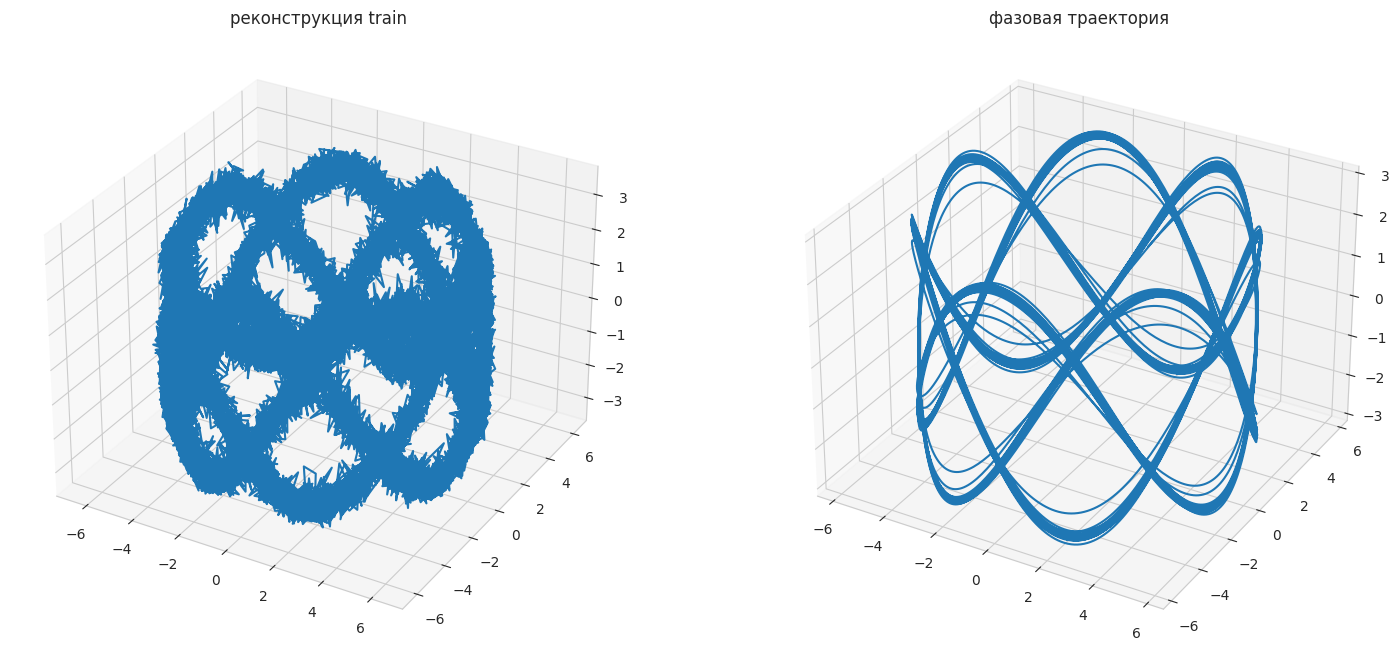

In [358]:
from matplotlib import projections

y_train_cpu = y_train.cpu()


plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1, projection="3d")

plt.title("реконструкция train")
plt.plot(phase_trajectory[:, 0], phase_trajectory[:, 1], phase_trajectory[:, 2])

plt.subplot(1, 2, 2, projection="3d")

plt.title("фазовая траектория")
plt.plot(y_train_cpu[:, 0], y_train_cpu[:, 1], y_train_cpu[:, 2])

plt.show()

In [359]:
X_test_windows, y_test_windows = make_windows(X_test, y_test, window_size=fs, stride=fs)

test_dataset = torch.utils.data.TensorDataset(X_test_windows, y_test_windows)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False)

In [360]:
phase_trajectory = []

total_loss = 0
total_phase_loss = 0
total_reconstruction_loss = 0

with torch.no_grad():
    for X_batch, Y_batch in test_dataloader:
        out, reconstruction = model(X_batch)
        phase_trajectory.append(out.cpu())

        phase_loss = loss_fn(out, Y_batch)
        reconstruction_loss = loss_fn(reconstruction, X_batch)

        loss = phase_loss + 0.5 * reconstruction_loss

        total_loss += loss.item()
        total_phase_loss += phase_loss.item()
        total_reconstruction_loss += reconstruction_loss.item()

    print(
        f"Epoch {epoch}: loss={total_loss / len(test_dataloader)}, phase={total_phase_loss / len(test_dataloader)}, recon={total_reconstruction_loss /  len(test_dataloader)}"
    )

phase_trajectory = torch.cat(phase_trajectory).reshape(
    -1, phase_trajectory[0].shape[-1]
)

Epoch 19: loss=0.09055829420685768, phase=0.0773262120783329, recon=0.02646416798233986


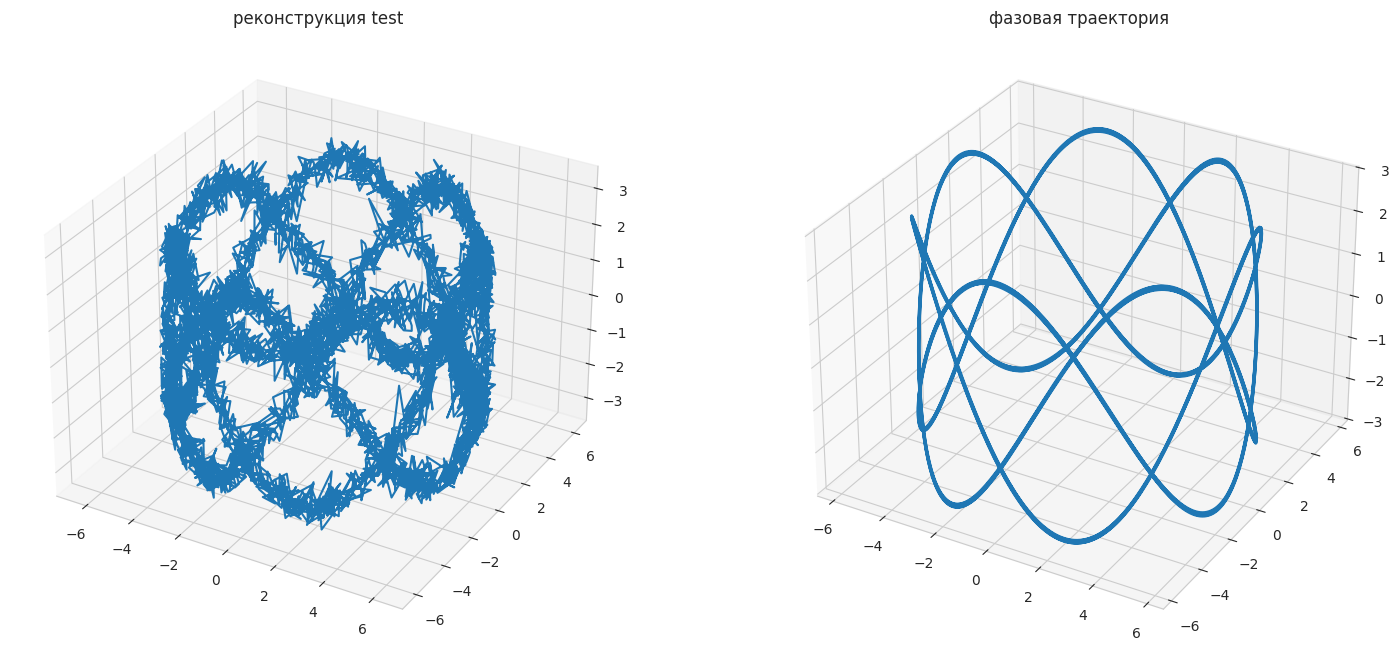

In [361]:
from matplotlib import projections

y_test_cpu = y_test.cpu()


plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1, projection="3d")

plt.title("реконструкция test")
plt.plot(phase_trajectory[:, 0], phase_trajectory[:, 1], phase_trajectory[:, 2])

plt.subplot(1, 2, 2, projection="3d")

plt.title("фазовая траектория")
plt.plot(y_test_cpu[:, 0], y_test_cpu[:, 1], y_test_cpu[:, 2])

plt.show()

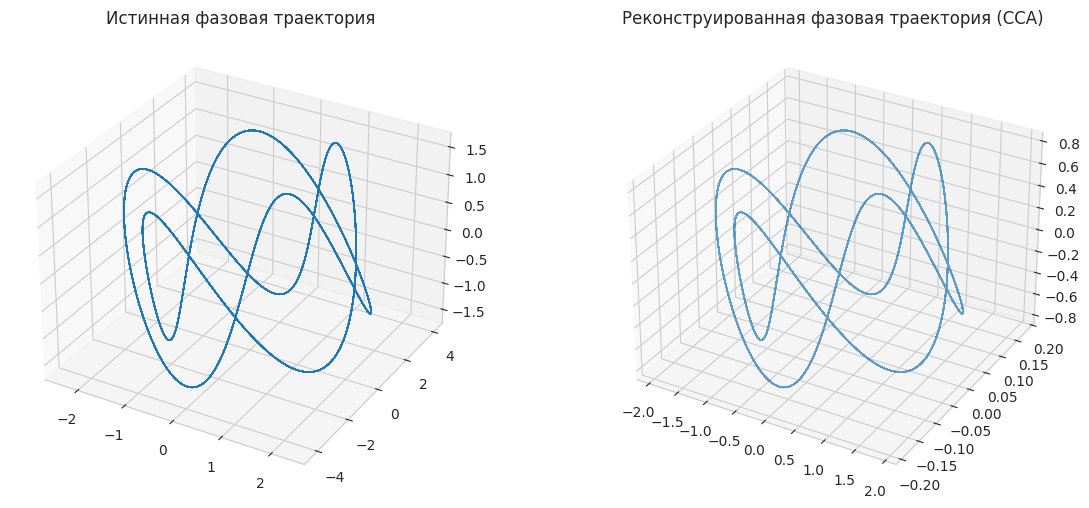

In [339]:
n_points = 20000
t = np.linspace(0, 40 * np.pi, n_points, endpoint=False)
signal = np.sin(t) + 0.3 * np.sin(2.5 * t)

tau1 = 18
dim1 = 10
emb1 = delay_embedding(signal, dim1, tau1)

tau2 = 25
dim2 = 15
emb2 = delay_embedding(signal, dim2, tau2)

min_len = min(len(emb1), len(emb2))
X_embed = emb1[:min_len]
Y_embed = emb2[:min_len]


X_reconstructed, Y_embed = CCA(n_components=3).fit_transform(X_embed, Y_embed)

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot(Y_embed[:, 0], Y_embed[:, 1], Y_embed[:, 2], lw=1.0, label="Истинная")
ax1.set_title("Истинная фазовая траектория")

ax2 = fig.add_subplot(122, projection="3d")
ax2.plot(
    X_reconstructed[:, 0],
    X_reconstructed[:, 1],
    X_reconstructed[:, 2],
    lw=1.0,
    alpha=0.7,
    label="Реконструкция",
)
ax2.set_title("Реконструированная фазовая траектория (CCA)")
plt.show()

In [343]:
T = 3000
t = np.linspace(0, 10, T)
signal = np.sin(2 * np.pi * 1.0 * t) + 0.5 * np.sin(2 * np.pi * 3.3 * t)

tau = 4

X = delay_embedding(signal, 2, tau)
N = X.shape[0]


m = 22
A = np.random.standard_normal((m, 2))
Q, _ = np.linalg.qr(A)
Y = X @ Q.T
Yc = Y - Y.mean(axis=0)

U, S, Vt = np.linalg.svd(Yc, full_matrices=False)

In [344]:
X = torch.tensor(Yc, dtype=torch.float64, device=device)

k_max = 22
sv_autograd = []
V_autograd = []
X_work = X.clone()

for k in range(k_max):
    d = X_work.shape[1]
    XtX = X_work.t() @ X_work
    v = torch.randn(d, dtype=torch.float64, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([v], lr=0.5)
    steps = 500
    prev = None

    for it in range(steps):
        optimizer.zero_grad()
        v_norm = v / (v.norm() + 1e-12)
        XtXv = XtX @ v_norm
        rq = v_norm @ XtXv
        loss = -rq
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        v_final = v / (v.norm() + 1e-12)
        Xv = X_work @ v_final
        sigma_sq = (Xv @ Xv).item()
        sigma = np.sqrt(max(sigma_sq, 0.0))
        sv_autograd.append(sigma)
        V_autograd.append(v_final.cpu().numpy())
        if sigma > 1e-16:
            u = Xv / (sigma + 1e-12)
            X_work = X_work - (sigma * u.unsqueeze(1) @ v_final.unsqueeze(0))
        else:
            break

sv_autograd = np.array(sv_autograd)

In [345]:
print("difference: ", max(abs(sv_autograd[:2] - S[:2])))

difference:  3.225864020350855e-12
